In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.stats import ks_2samp
from scipy.spatial import cKDTree
from scipy.interpolate import make_interp_spline
from sklearn.neighbors import KernelDensity
import math
import os

In [2]:
outdir = 'FigureS5_BCD'
if not os.path.exists(outdir):
    os.mkdir(outdir)

## FigureS5_B

In [3]:
obj = sc.read('Adult.h5ad')
df = pd.read_csv('Adult_telencephalon_rep2_DP8400015234BLA3_1_SCT_Removed.meta_0305.csv', index_col=0)
obj.obs['spatial_leiden'] = df['spatial_leiden']  # brain region annotation
obj

AnnData object with n_obs × n_vars = 8243 × 22144
    obs: 'CellID', 'Batch', 'Annotation', 'cell_id', 'Annotation_0305', 'spatial_leiden'
    var: 'Gene'
    uns: 'Batch1_Adult_telencephalon_rep2_DP8400015234BLA3_1', 'angle_dict'
    obsm: 'spatial'
    layers: 'counts'

In [4]:
df = pd.read_csv('bin1_matrix/Adult.gem.gz', sep='\t', comment='#')
m, n = df['x'].min(), df['y'].min()
a, b = df['x'].max()-m, df['y'].max()-n
df = df.loc[df['geneID']=='AMEX60DD003175', :]
df['x'] -= m
df['y'] -= n
df

,x,y,MIDCounts,geneID
454,2314,13,1,AMEX60DD003175
455,2360,21,1,AMEX60DD003175
456,2384,4,1,AMEX60DD003175
457,2493,35,1,AMEX60DD003175
458,2561,30,1,AMEX60DD003175
...,...,...,...,...
42376743,2435,6071,3,AMEX60DD003175
42376744,2578,6059,2,AMEX60DD003175
42376745,2723,6075,1,AMEX60DD003175
42376746,2834,6066,5,AMEX60DD003175


In [5]:
def get_area(x):
    id_ = x['cell_id']
    area = (obj.uns['Batch1_Adult_telencephalon_rep2_DP8400015234BLA3_1']['seg_cell']==id_).sum()
    return area

In [6]:
%%time
obj.obs.loc[:, 'area'] = obj.obs.apply(get_area, axis=1)

Wall time: 7min 3s


In [7]:
obj.obs.loc[:, 'r'] = (obj.obs['area']/np.pi)**0.5

In [8]:
def get_cell_center(obj):
    obj = obj.copy()
    coor = pd.DataFrame(obj.uns['Batch1_Adult_telencephalon_rep2_DP8400015234BLA3_1']['seg_cell'].flatten(), columns=['cell'])
    coor = coor[coor['cell'] > 0]
    coor[['x', 'y']] = np.argwhere(obj.uns['Batch1_Adult_telencephalon_rep2_DP8400015234BLA3_1']['seg_cell'] > 0)
    obj.obsm['cell_center'] = coor.groupby('cell').mean().values
    return obj

In [9]:
obj = get_cell_center(obj)

In [10]:
sub_obj = obj[(obj.obs['Annotation']=='sstIN'),:]

In [11]:
coor = sub_obj.obsm['cell_center']
point_tree = cKDTree(coor)

In [12]:
def get_r(x):
    d, _ = point_tree.query((x['x'], x['y']), k=1)
    return d

In [13]:
df.loc[:, 'r'] = df.apply(get_r, axis=1)
df.head()

,x,y,MIDCounts,geneID,r
454,2314,13,1,AMEX60DD003175,1303.972029
455,2360,21,1,AMEX60DD003175,1286.186080
456,2384,4,1,AMEX60DD003175,1298.307458
457,2493,35,1,AMEX60DD003175,1236.520524
458,2561,30,1,AMEX60DD003175,1214.493574


In [14]:
def get_means(df, m=50,nbins=50):
    r0 = df['r']/2
    d0 = df['MIDCounts']/(2*np.pi*r0)
    bins = np.linspace(0, m/2, nbins)
    digitized = np.digitize(r0, bins)
    bin_means = np.array([d0[digitized == i].sum()/((bins[1]-bins[0])*sub_obj.n_obs) for i in range(1, len(bins))])
    bin_means[np.isnan(bin_means)] = 0
    # note: 
    x_smooth = np.linspace(bins[:-1].min(), bins[:-1].max(), 300)
    y_smooth = make_interp_spline(bins[:-1], bin_means)(x_smooth)
    
    return bin_means, [x_smooth, y_smooth]

mean r: 7.282304557683422


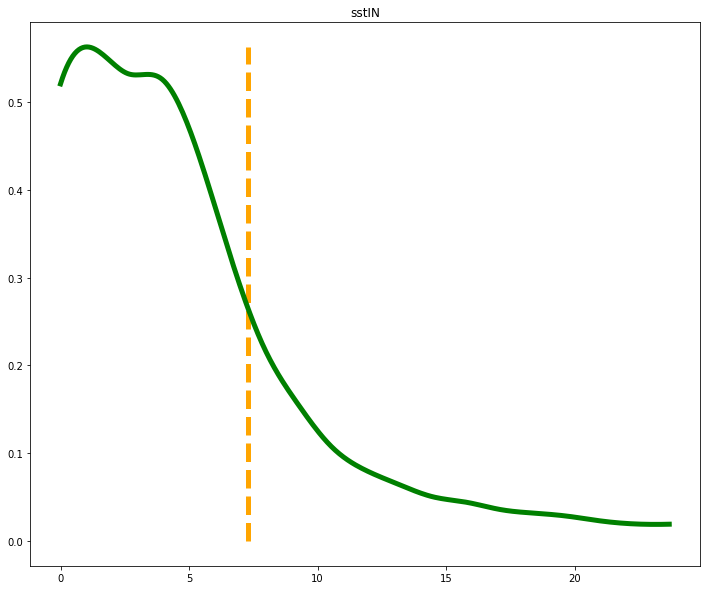

In [15]:
sst_means, sst_smooth = get_means(df, m=50, nbins=20)
plt.figure(figsize=(12,10))
x_smooth = sst_smooth[0]
y_smooth = sst_smooth[1]
plt.plot(x_smooth, y_smooth, linewidth=5, color='green')
plt.vlines(sub_obj.obs['r'].mean()/2, ymin=0,ymax=y_smooth.max(), color='orange', linestyle='--', linewidth=5)
plt.title('sstIN')
plt.savefig(os.path.join(outdir, 'sstIN_distribution.pdf'))
print('mean r:', sub_obj.obs['r'].mean()/2)

## FigureS5_C

In [16]:
from matplotlib.patches import FancyBboxPatch
from matplotlib.path import get_path_collection_extents
from scipy.stats import ks_2samp

In [17]:
def box_ax(ax):
    new_patches = []
    for patch in reversed(ax.artists):
        bb = patch.get_path().get_extents()
        color = patch.get_facecolor()
        patch.set_edgecolor(color)
    return ax

In [18]:
def plot_nebor_sig(gene, gene_name, y1, y2, sig1, sig2,colors, h=0.2, obj=obj, k=5, **kwargs):
    data = obj[:, gene].to_df()
    data['Celltype'] = obj.obs['Annotation']
    data['A'] = 'other'
    data.loc[data['Celltype']=='sstIN', 'A'] = 'sstIN'
    point_tree2 = cKDTree(obj.obsm['cell_center'])
    neighbours = []
    coor = obj.obsm['cell_center']
    
    for spot, spot_coor in zip(obj.obs_names, coor):
        if data.loc[spot, 'A'] == 'sstIN':
            _, n_index = point_tree2.query(spot_coor, k=k*3)
            count = 0
            for i in data.index[n_index[1:]]:
                if data.loc[i, 'A'] != 'sstIN':
                    count += 1
                    data.loc[i, 'A'] = 'Neighbours'
                    if count >= k:
                        break
    labels = ["sstIN","Neighbours","MP others"]
    my_type = pd.CategoricalDtype(
      categories=labels,
      ordered=True
    )
    data['A'] = data['A'].astype(my_type)
    # plt.figure(figsize=(8, 12))
    fig, ax = plt.subplots(figsize=(8, 12))
    for i in range(len(labels)):
        kwargs['boxprops']['facecolor'] = colors[i]
        kwargs['boxprops']['color'] = colors[i]
        plt.boxplot(data[gene][data['A']==labels[i]], labels=[labels[i]],positions=[i], **kwargs)
    print(ks_2samp(data.loc[data['A']=='Neighbours', gene], data.loc[data['A']=='sstIN', gene]))
    print(ks_2samp(data.loc[data['A']=='Neighbours', gene], data.loc[data['A']=='MP others', gene]))
    x1, x2 = 0 , 1
    y= y1
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c="k")
    ax.text((x1+x2)*.5, y+h, sig1, ha='center', va='bottom', color="k", fontsize=15)

    x1, x2 = 1 , 2
    y= y2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c="k")
    ax.text((x1+x2)*.5, y+h, sig2, ha='center', va='bottom', color="k", fontsize=15)
    # ax = box_ax(ax)
    sns.despine(left=True)
    plt.title(f'{gene_name} {gene}')
    plt.ylabel('Expression')

In [19]:
mp_obj = obj[obj.obs['spatial_leiden']==3, :]

KstestResult(statistic=0.9440786832597351, pvalue=9.992007221626409e-16)
KstestResult(statistic=0.29378037944911933, pvalue=2.55351295663786e-15)


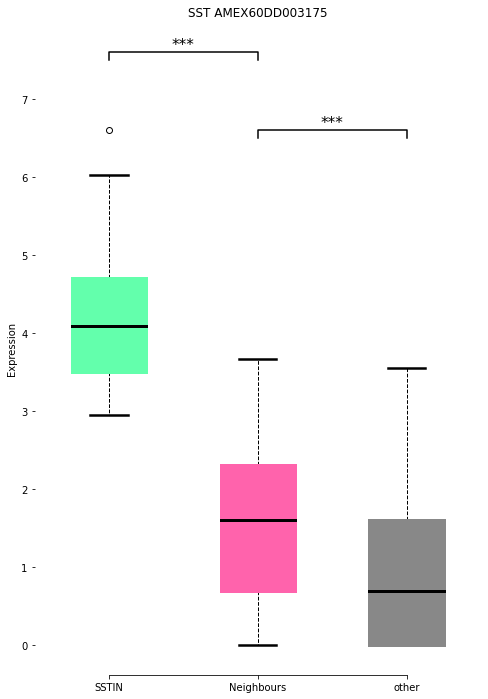

In [20]:
kw = dict(
    notch = False,sym = 'o',
    patch_artist = True,
    boxprops = {'linewidth':3},
    flierprops = {'marker':'o', 'color':'black', 'linewidth':.1},
    medianprops = {'linestyle':'-', 'color':'black', 'linewidth':3},
    whiskerprops = {'linestyle':'--'},
    capprops = {'linewidth':2.5},
    widths=.5,
)
plot_nebor_sig('AMEX60DD003175', 'SST', 7.5, 6.5, '***', '***',h=0.1, obj=mp_obj,colors=['#63FFAC', '#ff63ac', '#888888'], **kw)
sns.despine(trim=True, left=True)
plt.savefig(os.path.join(outdir, 'sstIN_SST.pdf'))

KstestResult(statistic=0.42356483340024087, pvalue=1.006750238730092e-11)
KstestResult(statistic=0.07298907646474677, pvalue=0.23863521944324417)


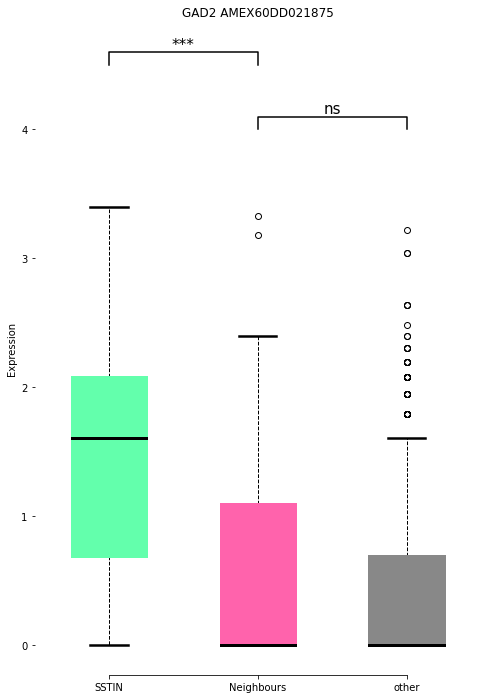

In [21]:
kw = dict(
    notch = False,sym = 'o',
    patch_artist = True,
    boxprops = {'linewidth':3},
    flierprops = {'marker':'o', 'color':'black', 'linewidth':.1},
    medianprops = {'linestyle':'-', 'color':'black', 'linewidth':3},
    whiskerprops = {'linestyle':'--'},
    capprops = {'linewidth':2.5},
    widths=.5,
)
plot_nebor_sig('AMEX60DD021875', 'GAD2', 4.5, 4.0, '***', 'ns', h=0.1, obj=mp_obj,colors=['#63FFAC', '#ff63ac', '#888888'], **kw)
sns.despine(trim=True, left=True)
plt.savefig(os.path.join(outdir, 'sstIN_GAD2.pdf'))

## FigureS5_D

In [22]:
def get_data(data,center,h,H):
    expr = (data['x']>=center[0]-h/2) & (data['x']<center[0]+h/2) & (data['y']>=center[1]-h/2) & (data['y']<center[1]+h/2)
    data = data[expr]
    data['x'] -= center[0]-H//2
    data['y'] -= center[1]-H//2
    return data

In [23]:
def get_c(npy,obj,h,H=50*2):
    contours = []
    contours_sst = []
    for id_ in np.unique(npy):
        if id_ < 1:
            continue
        arr = np.zeros_like(npy, dtype=np.uint8)
        arr[npy==id_] = 255
        contours_, hierarchy = cv2.findContours(arr,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_TC89_L1)
        c = contours_[0] - np.array([(h-H)//2, (h-H)//2]) # [[[i[0][0]-(h-H)//2,i[0][1]-(h-H)//2]] for i in contours_[0]]
        contours.append(c)
        # print(id_)
        if id_ in obj.obs['cell_id'].tolist():
            contours_sst.append(c)
    return contours, contours_sst

In [25]:
def kde(df, gene=None, gene_name=None, l=[5,10,15,20], t=99.99,h=50*2, 
        kernel='tophat',name=None,fg=None):
    if gene:
        cbs = df.loc[df['geneID']==gene, :]
    else:
        cbs = df.copy()
    for i in l:
        kde = KernelDensity(kernel=kernel, 
                        bandwidth=i).fit(X=cbs[['x', 'y']], 
                                          sample_weight=cbs['MIDCounts'])
        xx, yy = np.mgrid[0:h, 0:h]
        log_d = kde.score_samples(np.vstack([xx.ravel(), yy.ravel()]).T)    
        m = np.exp(log_d.reshape(xx.shape))
        n = m.copy()
        if t < 100:
            m = np.clip(m, m.min(), np.percentile(m, t))
        m -= m.min()
        m /= m.max()
        m = (m*255).astype(np.uint8)
        mm = cv2.applyColorMap(m, cv2.COLORMAP_JET)
        if fg is not None:
            mm = np.insert(mm, 3, 255, 2)
            mm[fg[:,:,3]==255] = fg[fg[:,:,3]==255]
#         plt.figure()
#         plt.imshow(mm)
        cv2.imwrite(os.path.join(outdir,f'{name}_{kernel}_mm{i}_{gene_name}_{gene}.png'), mm)

In [26]:
cells = [1761, 5498, 5959, 7464, 558, 9931, 10389]
centers = [[1541, 2174],
           [2662, 4105],
           [2805, 2506],
           [3286, 4403],
           [1098, 2380],
           [4096, 3786],
           [4336, 4025]]
h=85*2
H=80*2
for cell_id, center in zip(cells, centers):
    data = get_data(df, center, h,H)
    npy = sub_obj.uns['Batch1_Adult_telencephalon_rep2_DP8400015234BLA3_1']['seg_cell'][center[0]-h//2:center[0]+h//2, center[1]-h//2:center[1]+h//2]
    contours,contours_sst  = get_c(npy,sub_obj, h,H)
    arr =  np.zeros((H, H, 4), dtype=np.uint8)
    arr = cv2.drawContours(arr,contours,-1,(255,255,255,255), 2)
    arr = cv2.drawContours(arr,contours_sst,-1,(239,110,255, 255), 2)

    kde(data, gene='AMEX60DD003175', gene_name='sst', name=f'adult_{cell_id}', l=[5],
       kernel='gaussian', t=99.98, h=H, fg=arr)

C:\Users\WANGSH~1\AppData\Local\Temp/ipykernel_25984/3265364252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['x'] -= center[0]-H//2
C:\Users\WANGSH~1\AppData\Local\Temp/ipykernel_25984/3265364252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'] -= center[1]-H//2
C:\Users\WANGSH~1\AppData\Local\Temp/ipykernel_25984/3265364252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t